In [22]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [4]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name','sex','is_cheater','has_email']

In [5]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонрк с типом данных object
    
    Arg:
        df: pd.DataFrame
        obj_col: str 
    Return:
        pd.DataFrame
    '''
    label_encoder = LabelEncoder()
    for column in df[obj_cols]:
        encoded_column = label_encoder.fit_transform(df[column])
        new_column_name = column + "_level"
        df[new_column_name] = encoded_column
    df.drop(obj_cols,axis=1,inplace=True)
        
    return df

In [6]:
df = prepare_obj_data(df, obj_cols)

In [7]:
df.drop(['date_install','first_command_time','birthday','time_confirm_email'],axis=1,inplace=True)

In [8]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [9]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y_stratified, random_state=42)


In [14]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

## Classification

In [10]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [27]:
def plot_importance_reg(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [11]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [16]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

In [28]:
def train_model_reg(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance_reg(model, X_train)
    
    return model, td

RandomForestClassifier(n_jobs=-1, random_state=42)
Cross_validation: [0.90265928 0.90835996 0.91221261 0.91575094 0.90730592]


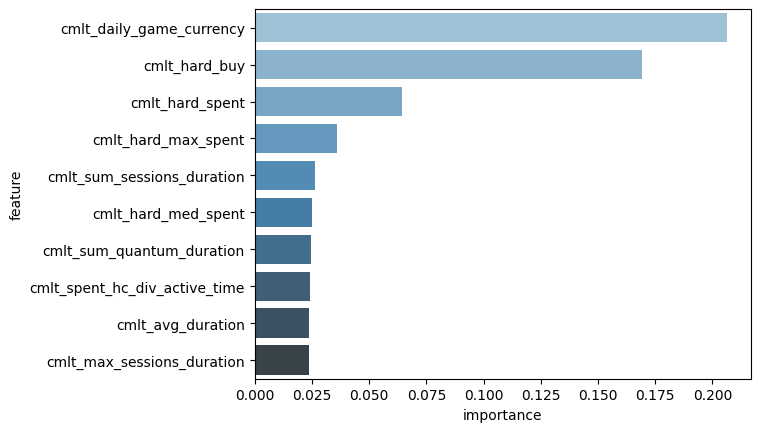

In [19]:
model, features = train_model(RandomForestClassifier(random_state=42,n_jobs=-1),
                              X_train, 
                              y_train_binary,
                              5,
                              scoring='roc_auc',
                              cross_val=True)

In [20]:
X_train_regression = X_train[y_train_binary == 1]
y_train_regression = y_train[y_train_binary == 1]

Lasso(alpha=1, random_state=42)
Cross_validation: [-1.40943532 -1.38318994 -1.40188586 -1.36955833 -1.39748683]


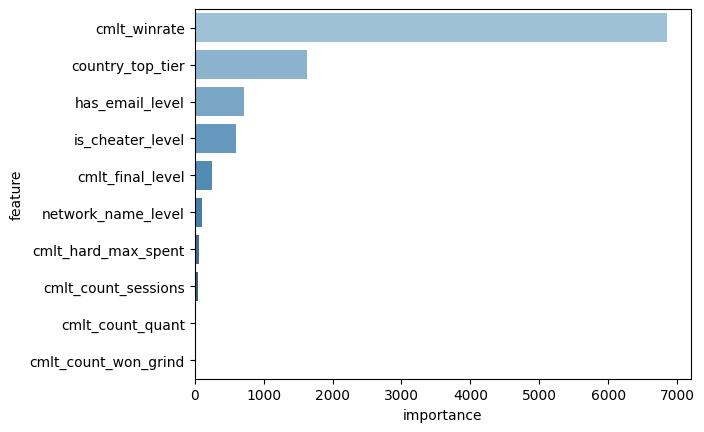

In [29]:
model_reg, features_reg = train_model_reg(Lasso(alpha=1, random_state=42),
                              X_train_regression, 
                              y_train_regression,
                              5,
                              scoring=custom_smape_score,
                              cross_val=True)

In [ ]:
y_pred_train = model.predict(X_train_regression)
y_pred_test = model.predict(X_test)

In [ ]:
np.zeros_like(y_train)

In [30]:
np.zeros_like(y_test)

array([0., 0., 0., ..., 0., 0., 0.])